In [1]:
'''
Date: 2022-09-12 10:27:57
LastEditTime: 2022-09-12 13:39:29
LastEditors: Li Xiang
Description: 
FilePath: /Pytorch-Linear-Regression/net.ipynb
'''

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from tqdm import trange

import numpy as np
import math


# load the mnist dataset

data = []

for i in range(2000):
  value = []
  for t in range(2):
    # rand = random.gauss(0, 1)
    rand = random.uniform(-2, 2)
    value.append(rand)
  # labels = math.sin(value[0])
  labels = value[0]*value[0]+value[1]*value[1]
  data.append((value, labels))


x = []
y = []
for i in range(len(data)):
  x.append(data[i][0])
  y.append(data[i][1])

xTensor = torch.Tensor(np.array(x)).cuda()
yTensor = torch.Tensor(np.array(y)).cuda()


In [2]:

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_dim = 2
        self.hidden_dim = 10
        self.output_dim = 1
        self.hidden_layer_num = 4
        self.l1 = nn.Linear(2, 1)
        layers = [nn.Linear(self.input_dim, self.hidden_dim), nn.ReLU()]
        for i in range(self.hidden_layer_num):
          layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
          layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        out = self.net(x)
        return out


model = Net().cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-4,weight_decay=1e-2)

batch_size=4

max_step=1000
for epoch in (t := trange(max_step)):
    batch_cnt=0
    batch_val=[]
    batch_lab=[]
    
    values = xTensor
    labels = yTensor
    output = model(values)

    optimizer.zero_grad()

    loss = criterion(output, labels.unsqueeze(1))
    loss.backward()

    optimizer.step()
    if epoch % 100==0:
        print("loss: ", loss)

print("loss: ", loss)
print('finished')
X_STEP = 100
Y_STEP = 100
xs = torch.linspace(-2, 2, steps=X_STEP)
ys = torch.linspace(-2, 2, steps=Y_STEP)
grid_x, grid_y = torch.meshgrid(xs, ys)

grid = torch.stack([grid_x, grid_y], dim=-1)
grid = grid.reshape(-1, 2).cuda()
out = model(grid)

plot_points = torch.cat([grid, out], dim=1)

  5%|▌         | 52/1000 [00:00<00:06, 141.12it/s]

loss:  tensor(10.2076, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 148/1000 [00:00<00:02, 304.50it/s]

loss:  tensor(2.7093, device='cuda:0', grad_fn=<MseLossBackward>)
loss:  

 25%|██▌       | 250/1000 [00:00<00:01, 403.45it/s]

tensor(2.7040, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 353/1000 [00:01<00:01, 455.77it/s]

loss:  tensor(2.7039, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 450/1000 [00:01<00:01, 415.88it/s]

loss:  tensor(2.7037, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 540/1000 [00:01<00:01, 430.08it/s]

loss:  tensor(2.7036, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 673/1000 [00:01<00:00, 387.62it/s]

loss:  tensor(2.7035, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 757/1000 [00:02<00:00, 402.25it/s]

loss:  tensor(2.7033, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 858/1000 [00:02<00:00, 452.18it/s]

loss:  tensor(2.7032, device='cuda:0', grad_fn=<MseLossBackward>)
loss:  tensor(2.7031, device='cuda:0', grad_fn=<MseLossBackward>)


100%|██████████| 1000/1000 [00:02<00:00, 382.07it/s]


loss:  tensor(2.7030, device='cuda:0', grad_fn=<MseLossBackward>)
finished


/tmp/ipykernel_9068/3776212211.py:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


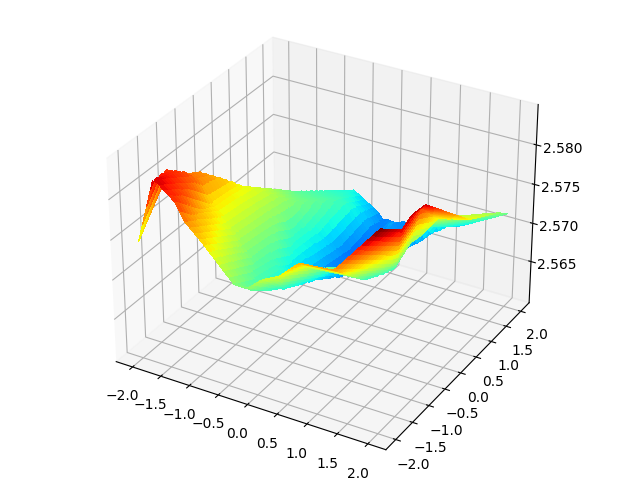

In [3]:

# for creating a responsive plot
from matplotlib.ticker import LinearLocator
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

# importing required libraries

plot_points = plot_points.detach().cpu()
fig = plt.figure()
ax = Axes3D(fig)

# creating the plot
# plot_geeks = ax.scatter(plot_points[...,0], plot_points[...,1], plot_points[...,2], color='green')
surf_points = plot_points.reshape(X_STEP, Y_STEP, 3)
surf_points_x = surf_points[..., 0]
surf_points_y = surf_points[..., 1]
surf_points_z = surf_points[..., 2]
surf = ax.plot_surface(surf_points_x, surf_points_y, surf_points_z, cmap=cm.jet,
                       linewidth=0, antialiased=False)
pass
# torch.save(model, "cnn.pt")
